## Visualizações

Nesse notebook são feitas as visualizações dos dados agregados

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from utils.load_csv import load_csv

In [2]:
pop_afetada_onibus = load_csv('pop_afetada_onibus.csv')

pop_afetada_linha = load_csv('pop_afetada_linha.csv')

pop_afetada_distrito = load_csv('pop_afetada_distrito.csv')

População afetada por ônibus

In [3]:
top10_onibus = (pop_afetada_onibus.sort_values("pop_buffer", ascending=False).head(10).sort_values("pop_buffer"))

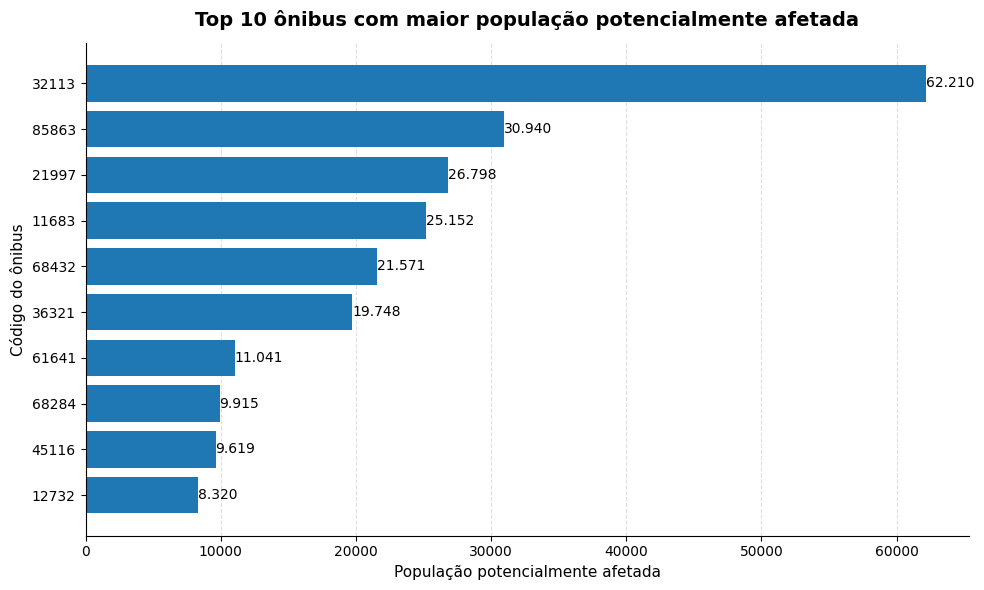

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.barh(top10_onibus["cd_onibus"].astype(str),
               top10_onibus["pop_buffer"])

ax.set_title("Top 10 ônibus com maior população potencialmente afetada",
             fontsize=14,
             weight="bold",
             pad=12)

ax.set_xlabel("População potencialmente afetada", fontsize=11)
ax.set_ylabel("Código do ônibus", fontsize=11)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.grid(axis="x", linestyle="--", alpha=0.4)
ax.set_axisbelow(True)

for bar in bars:
    width = bar.get_width()
    ax.text(width,
            bar.get_y() + bar.get_height() / 2,
            f"{int(width):,}".replace(",", "."),
            va="center",
            ha="left",
            fontsize=10)

plt.tight_layout()

plt.show()

População afetada por linha

In [5]:
col_linha = "nm_linha"  # "nm_linha" / "cd_linha" / "nm_onibus"

top10_linha = (pop_afetada_linha.sort_values("pop_buffer", ascending=False).head(10).sort_values("pop_buffer"))

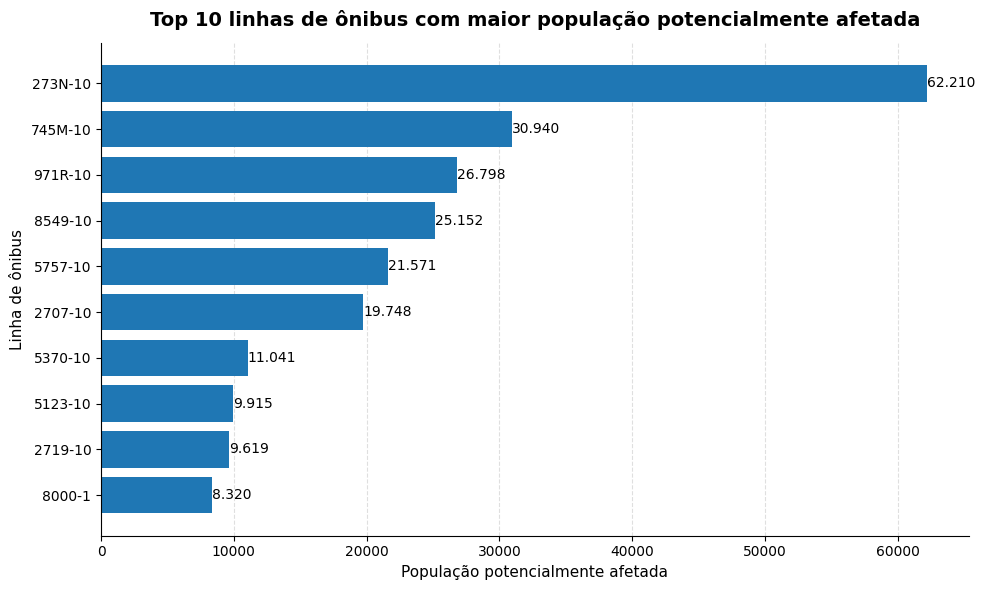

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.barh(top10_linha[col_linha].astype(str),
               top10_linha["pop_buffer"])

ax.set_title("Top 10 linhas de ônibus com maior população potencialmente afetada",
             fontsize=14,
             weight="bold",
             pad=12)

ax.set_xlabel("População potencialmente afetada", fontsize=11)
ax.set_ylabel("Linha de ônibus", fontsize=11)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.grid(axis="x", linestyle="--", alpha=0.4)
ax.set_axisbelow(True)

for bar in bars:
    width = bar.get_width()
    ax.text(width,
            bar.get_y() + bar.get_height() / 2,
            f"{int(width):,}".replace(",", "."),
            va="center",
            ha="left",
            fontsize=10)

plt.tight_layout()

plt.show()

População afetada por distrito

In [7]:
import geopandas as gpd
import requests
from io import BytesIO
import os
from config import data_folder
from utils.load_shp import load_shp
from utils.save_shp import save_shp

def download_distritos():

    file = os.path.join(data_folder, "distritos.shp")

    if os.path.exists(file):
        print("Retornando arquivo salvo")
        return gpd.read_file(file)

    print("Carregando do GeoSampa")

    url = ("http://wfs.geosampa.prefeitura.sp.gov.br/geoserver/geoportal/"
           "wfs?version=1.0.0&request=GetFeature&output"
           "Format=SHAPE-ZIP&typeName=geoportal:distrito_municipal")

    with requests.get(url) as r:
        content = BytesIO(r.content)
        gdf_distritos = gpd.read_file(content)

    save_shp(gdf_distritos, "distritos.shp")

    return gdf_distritos

import warnings
warnings.filterwarnings("ignore", category = RuntimeWarning)

download_distritos();

distritos = load_shp("distritos.shp")

Retornando arquivo salvo


In [8]:
pop_afetada_distrito["NM_DIST"] = (pop_afetada_distrito["NM_DIST"].str.upper().str.strip())

distritos["nm_distrit"] = (distritos["nm_distrit"].str.upper().str.strip())

gdf = distritos.merge(pop_afetada_distrito,
                      left_on="nm_distrit",
                      right_on="NM_DIST",
                      how="left")

gdf["pop_buffer"] = gdf["pop_buffer"].fillna(0)

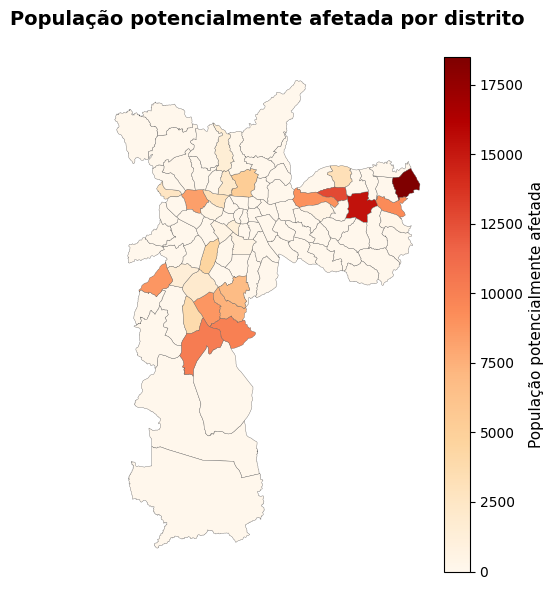

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

cmap = "OrRd"

norm = Normalize(vmin=gdf["pop_buffer"].min(),
                 vmax=gdf["pop_buffer"].max())

gdf.plot(column="pop_buffer",
         cmap=cmap,
         linewidth=0.25,
         edgecolor="#5a5a5a",
         ax=ax,
         legend=False)

sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cbar = fig.colorbar(sm,
                    ax=ax,
                    fraction=0.03,
                    pad=0.01)

cbar.set_label("População potencialmente afetada",
               fontsize=11)

ax.set_title("População potencialmente afetada por distrito",
             fontsize=14,
             fontweight="bold",
             loc="center",
             pad=12)

ax.axis("off")

plt.tight_layout()

plt.show()